<a href="https://colab.research.google.com/github/escaduto/FireSpread/blob/master/RAWS_Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Stations & Fire Spread


## Setup

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

In [4]:
%cd "/content/drive/My Drive/FireDrivers_Paper" 

import os
rootPath = "/content/drive/My Drive/FireDrivers_Paper/WeatherStation_FireSpread"
os.chdir(rootPath)

/content/drive/My Drive/FireDrivers_Paper


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       26751672 kB


In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [9]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import rtree

In [10]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext):
              file_list.append(os.path.join(path,names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath 

## Get Nearest RAWS Info

In [ ]:
raws_shp_list = lstFiles("data/RAWS", ".shp")

raws_info = pd.read_csv("data/RAWS/Raws_Info.csv")
raws_info = raws_info.drop(columns=['Unnamed: 0'])

In [ ]:
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np
import pandas as pd
import geopandas as gpd

geometry = [Point(xy) for xy in zip(raws_info.decimal_long, raws_info.decimal_lat)]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(raws_info, crs=crs, geometry=geometry)
geo_df.sort_values(by=['station'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,abbrv,end_year,start_year,station,url,latitude,longitude,decimal_lat,decimal_long,geometry
403,ACT,2019,1995,Acton,/cgi-bin/rawMAIN.pl?caCACT,"34° 26' 45.00""N","118° 12' 00.00""W",34.445833,-118.200000,POINT (-118.20000 34.44583)
329,ALC,2019,2017,Alcalde,/cgi-bin/rawMAIN.pl?caCALC,"36° 11' 00.00""N","120° 29' 55.00""W",36.183333,-120.498611,POINT (-120.49861 36.18333)
406,ALC,2019,2017,Alcalde,/cgi-bin/rawMAIN.pl?caCALC,"36° 11' 00.00""N","120° 29' 55.00""W",36.183333,-120.498611,POINT (-120.49861 36.18333)
2,APT,2019,1991,Alder Point,/cgi-bin/rawMAIN.pl?caCAPT,"40° 11' 12.00""N","123° 35' 25.00""W",40.186667,-123.590278,POINT (-123.59028 40.18667)
191,ALD,2019,1994,Alder Springs,/cgi-bin/rawMAIN.pl?caCALD,"39° 39' 05.00""N","122° 43' 25.00""W",39.651389,-122.723611,POINT (-122.72361 39.65139)
...,...,...,...,...,...,...,...,...,...,...
397,WDY,2019,2010,Woody,/cgi-bin/rawMAIN.pl?caCWDY,"35° 42' 22.00""N","118° 49' 57.00""W",35.706111,-118.832500,POINT (-118.83250 35.70611)
628,WDY,2019,2010,Woody,/cgi-bin/rawMAIN.pl?caCWDY,"35° 42' 22.00""N","118° 49' 57.00""W",35.706111,-118.832500,POINT (-118.83250 35.70611)
188,YOL,2019,1990,Yolla Bolla,/cgi-bin/rawMAIN.pl?caCYOL,"40° 20' 18.00""N","123° 03' 54.00""W",40.338333,-123.065000,POINT (-123.06500 40.33833)
637,YUC,2019,1990,Yucca Valley,/cgi-bin/rawMAIN.pl?caCYUC,"34° 07' 24.00""N","116° 24' 28.00""W",34.123333,-116.407778,POINT (-116.40778 34.12333)


In [ ]:
fr_per = lstFiles(f'data/Merged_Daily_DIFF', '.shp')
fr_per

fire_list = []
year_list = []

for pth in fr_per:
  nm = os.path.basename(pth)
  nm = nm.split('_')
  fr = nm[0]
  yr = nm[1]
  fire_list.append(fr)
  year_list.append(yr)

In [ ]:
len(list(zip(fire_list, year_list)))

720

In [21]:
def getPerimeter(fire_nm, year):
  per_gdf = gpd.read_file(f'data/Merged_Daily_DIFF/{year}/{fire_nm}_{year}_MergedDIFF.shp')
  return(per_gdf)

def getNearestStation(fire_nm, year, raws_gdf):
  per_gdf = getPerimeter(fire_nm, year)
  per_gdf = per_gdf.to_crs(raws_gdf.crs)
  per_gdf['geometry'] = per_gdf.buffer(0.1)
  res_intersection = gpd.overlay(raws_gdf, per_gdf, how='intersection', keep_geom_type=True)
  return res_intersection['station'].unique().tolist()

def getStationInfo(fire_nm, year, raws_gdf):
  station_list = getNearestStation(fire_nm, year, raws_gdf)
  raws_df = geo_df[geo_df['station'].isin(station_list)].drop_duplicates()
  df = getPerimeter(fire_nm, year)
  
  raws_df['Fire_Start_Date'] = df['Date'].min()
  raws_df['Fire_End_Date'] = df['Date'].max()

  raws_df['Fire_Start_Date'] =  pd.to_datetime(raws_df['Fire_Start_Date'], format='%Y-%m-%d')
  raws_df['Fire_End_Date'] =  pd.to_datetime(raws_df['Fire_End_Date'], format='%Y-%m-%d')

  raws_df['Fire'] = fire_nm

  return raws_df

## Download RAWS Hourly Data as CSV

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup

In [ ]:
def scrape_data(url, fname, dt, station_name):
    response = requests.get(url, timeout=10)
    soup = BeautifulSoup(response.content, 'html.parser')
    table_rows = soup.find_all("tr",attrs={"class": "data"})

    data_val = []
    for dta in table_rows[:-4]: 
      td = dta.find_all('td')
      row = [i.text.replace('\n', ' ').strip() for i in td]
      row_witout_empty = list(filter(lambda x: x != '', row))
      
      data_val.append(row_witout_empty)

    
    row_head = ['Hour', 'Total_Solar_Rad', 'Wind_Avg_mph', 'Wind_Dir_Deg', 
                'Wind_Max_mph', 'Air_Temp_Avg', 'Fuel_Temp_Avg', 'Fuel_Moist_Per',
                'Rel_Hum_Per', 'Dew_Point_Deg', 'Wet_Bulb', 'Total_Precip']
    if len(row) != 0: 
      f_out = createFolder('data/RAWS_CSV', fname)
      with open(os.path.join(f_out, f'{fname}_{dt}_{station_name.strip()}.csv'), 'w') as csv_file:
          writer = csv.writer(csv_file)
          writer.writerow(row_head)
          for row in data_val:
              writer.writerow(row)

In [ ]:
import datetime
from datetime import date

def retrieveRAWS_saveIntoCSV(fire_nm, fire_yr, geo_df):
  df = getStationInfo(fire_nm, fire_yr, geo_df)
  for index, rows in df.iterrows(): 
    # grab fire, weather station name, url 
    sta_name = rows.station 
    start_date = rows.Fire_Start_Date - datetime.timedelta(days=2)
    end_date = rows.Fire_End_Date
    delta = end_date - start_date

    # get range of dates
    date_list = [end_date - datetime.timedelta(days=x) for x in range(delta.days)]

    for dy in date_list: 
      if rows.end_year >= dy.year:
        # plug into url 
        dy_str = str(dy.day)
        mth_str = str(dy.month).zfill(2)
        yr_str = str(dy.year)
        print(dy_str, mth_str, yr_str)
        url = f'https://raws.dri.edu/cgi-bin/wea_daysum2.pl?stn=c{rows.abbrv.lower()}&day={dy_str}&mon={mth_str}&yea={yr_str[-2:]}&unit=E'
        print(url)
        
        # web scrap 
        dt = yr_str + mth_str + dy_str
        scrape_data(url, rows.Fire, dt, rows.station)

In [ ]:
for fire_nm, fire_yr in list(zip(fire_list, year_list))[635:]:
  print(fire_nm, fire_yr)
  try: 
    retrieveRAWS_saveIntoCSV(fire_nm, fire_yr, geo_df)
  except: 
    print('error', fire_nm, fire_yr)
    continue

### Clean up CSV

In [ ]:
# add fire name, date, datetime, station name
csv_list = lstFiles('data/RAWS_CSV', '.csv')

def cleanCSV(csv_list):
  for csv in csv_list: 
    try: 
      nm = os.path.basename(csv)
      fr_nm = nm.split('_')[0]
      dt = nm.split('_')[1]
      st_nm = nm.split('_')[2][:-4]

      df = pd.read_csv(csv)
      df['Fire'] = fr_nm
      df['Date'] = dt

      df['Datetime'] = df['Date'].str.cat(df['Hour'],sep=" ")  
      df['Datetime'] =  pd.to_datetime(df['Datetime'], format='%Y%m%d %I %p')

      df['station'] = st_nm

      df.iloc[-1, df.columns.get_loc('Datetime')] = df.iloc[-1, df.columns.get_loc('Datetime')] + datetime.timedelta(days=1) 

      df.to_csv(csv)
      print(csv)
    except: 
      print('error', csv)
      continue

In [ ]:
cleanCSV(csv_list)

### Combine CSVS 

In [ ]:
raws_df = raws_info[['station', 'decimal_lat',	'decimal_long',	'geometry']]
raws_df = raws_df.applymap(lambda x: x.strip() if type(x)==str else x)

def combineCSV_byFire(fire_nm, fire_yr):
  csv_list = lstFiles(f'data/RAWS_CSV/{fire_nm}', '.csv')

  if len(csv_list) != 0:
    #combine all files in the list
    combined_csv = pd.concat([pd.read_csv(f, index_col=None) for f in csv_list])
    combined_csv = combined_csv.drop(columns=['Unnamed: 0'])
    #export to csv
    final_df = pd.merge(combined_csv, raws_df, how='left', on='station')
    final_df.to_csv( f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv", index=False)


In [ ]:
for fire_nm, fire_yr in list(zip(fire_list, year_list)):
  print(fire_nm, fire_yr)
  try: 
    combineCSV_byFire(fire_nm, fire_yr)
  except: 
    print('error', fire_nm, fire_yr)
    continue

## Get derived perimeter info

In [476]:
fl_path = '/content/drive/My Drive/FireDrivers_Paper/FinalCSV_Info'

def getDerivedDF(fl_path):
  derived_df = pd.read_csv(os.path.join(fl_path, 'FireInfoVar_Final.csv'), index_col=None)
  derived_df['YearJD'] = derived_df['Year'].astype('str').str.cat(derived_df['JulianDay'].astype('str'),sep="")  
  derived_df['Date'] = pd.to_datetime(derived_df['YearJD'], format= '%Y%j')
  derived_df['Date'] =  derived_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
  derived_df['Datetime'] = derived_df['Date'] + ' 23:00:00'
  derived_df['Area (ha)'] = derived_df['Area (ha)'] / 1000 
  return derived_df

### Visualize Time-series

Take Daily Average i.e. Values During DayTime 6am to 6pm 

In [340]:
import math
def calculateVPD(Temp_val, RH_val):
  VP_sat = 0.61078 * math.exp((Temp_val * 17.2694) / (Temp_val + 238.3))
  VP_air = (VP_sat * RH_val) / 100 
  VPD = VP_sat - VP_air 
  return VPD

In [341]:
def convertTemp_FtoC(Temp_val):
  C_TEMP = ((Temp_val - 32) * 5 ) / 9 
  return C_TEMP

In [374]:
night_list = ['7 pm', '8 pm', '9 pm', '10 pm','11 pm', '12 am','1 am', '2 am','3 am', '4 am', '5 am']
day_list = ['6 am', '7 am', '8 am', '9 am', '10 am','11 am', '12 pm','1 pm', '2 pm','3 pm', '4 pm', '5 pm', '6 pm']

def getDailyRAWS(fire_nm, fire_yr):
  rim_df = pd.read_csv(f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv")
  
  criteria = [rim_df['Hour'].isin(day_list), rim_df['Hour'].isin(night_list)]
  values = ['Day', 'Night']
  rim_df['Day_Night']  = np.select(criteria, values, 0)
  day_raws_df = rim_df.groupby(by=['Day_Night', 'Date', 'Fire']).agg({'Total_Solar_Rad': 'mean', 
                                                                    'Wind_Avg_mph': 'mean',
                                                                    'Wind_Dir_Deg': 'mean',
                                                                    'Wind_Max_mph': ['mean', 'max'],
                                                                    'Air_Temp_Avg': ['mean', 'max'],
                                                                    'Fuel_Temp_Avg': 'mean',
                                                                    'Fuel_Moist_Per': 'mean',
                                                                    'Rel_Hum_Per': 'mean',
                                                                    'Dew_Point_Deg': 'mean',
                                                                    'Wet_Bulb': 'mean',
                                                                    'Total_Precip': 'mean'}).reset_index()
  day_raws_df.columns = ['Day_Night', 'Date', 'Fire', 'Total_Solar_Rad', 'Wind_Avg_mph',
       'Wind_Dir_Deg', 'Wind_Max_Avg', 'Wind_Max_mph', 'Air_Temp_Avg', 'Air_Temp_Max',
       'Fuel_Temp_Avg', 'Fuel_Moist_Per', 'Rel_Hum_Per', 'Dew_Point_Deg',
       'Wet_Bulb', 'Total_Precip']

  day_raws_df['Air_Temp_Celcius'] = convertTemp_FtoC(day_raws_df['Air_Temp_Avg'])
  day_raws_df['Air_Temp_Max_Celcius'] = convertTemp_FtoC(day_raws_df['Air_Temp_Max'])
  day_raws_df['VPD'] = day_raws_df.apply(lambda x: calculateVPD(x['Air_Temp_Celcius'],x['Rel_Hum_Per']),axis=1)
  day_raws_df = day_raws_df[day_raws_df['Day_Night'] == 'Day']
  day_raws_df['Date'] = day_raws_df['Date'].astype('str')
  day_raws_df['Date'] = pd.to_datetime(day_raws_df['Date'], format= '%Y%m%d')
  day_raws_df['Date'] =  day_raws_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
  return day_raws_df

### Merge RAWS Daily w/ Fire Perimeter 

In [652]:
# add datetime, round down time 
# merge hectare with datetime as new column 
fire_nm = 'Woolsey'
fire_yr = '2018'

# RAWS 
day_raws_df = getDailyRAWS(fire_nm, fire_yr)

# PERIMETER
fire_df = getPerimeter(fire_nm, fire_yr)

# DERIVED
derived_df = getDerivedDF(fl_path)
derived_df = derived_df[derived_df['FireName'] == fire_nm]

In [653]:
derived_df = derived_df[['JulianDay', 'Date', 'Datetime', 'Area (ha)', 'DIR_WA', 'DIR_MaxDist', 'DIST_MEDSTD',
       'Magnitude (upperQ)', 'Magnitude (median)', 'FireName', 'Year',
       'NA_L3NAME', 'NA_L2NAME', 'ecoID', 'CONIFER', 'CONIFER_HA',
       'EXOTIC_HER', 'GRASSLAND', 'HARDWOOD', 'RIPARIAN', 'SHRUBLAND',
       'SPARSELY_V', 'URBAN', 'BARREN', 'DEVELOPED', 'AGRICULTURE',
       'deadfuelmoisture1000hr', 'minimumrelativehumidity','windfromdirection', 'windspeed',
       'meanvaporpressuredeficit']]

In [654]:
fire_df['Time'] = fire_df['Time'].astype('str').str.zfill(4)
fire_df['Time'] = fire_df['Time'] .map(lambda x: str(x)[:2] + ':00:00')
fire_df = fire_df.replace({'Time': '24:00:00'}, '23:00:00')
fire_df['Datetime'] = fire_df['Date'].str.cat(fire_df['Time'],sep=" ")  
fire_df['Datetime'] =  pd.to_datetime(fire_df['Datetime'] , format='%Y-%m-%d %H:%M:%S')

In [655]:
# day_raws_df['Datetime']=  pd.to_datetime(day_raws_df['Datetime'], format='%Y-%m-%d %H:%M:%S')

# fire_df['Datetime'] =  fire_df['Datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
# fire_df['Date'] =  fire_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# derived_df['Date'] =  derived_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

merged_rim_df = pd.merge(day_raws_df, fire_df, how='left', on='Date')
merged_rim_df = pd.merge(merged_rim_df, derived_df, how='left', on='Date')

In [656]:
merged_rim_df['Date']=  pd.to_datetime(merged_rim_df['Date'], format='%Y-%m-%d')
merged_rim_df['Interagency (ha)'] = merged_rim_df['Hectare'] / 1000 

In [657]:
merged_rim_df = merged_rim_df.rename(columns={ 'VPD': 'Vapor Pressure Deficit (kPa)',
                                              'windspeed': 'GRID Wind Velocity (mph)', 
                                              'Magnitude (upperQ)' : 'Magnitude (km)',
                                              'Area (ha)': 'Area Burned (ha)',
                                              'Wind_Avg_mph': 'RAWS Wind Velocity (mph)',
                                              'Air_Temp_Max_Celcius' : 'Max Air Temp (C)',
                                              'Wind_Max_mph': 'Max Wind Velocity (mph)'                                             
                                              })

### Plot Wind

In [636]:
wind_df_plot = merged_rim_df[[
 'Date',
 'GRID Wind Velocity (mph)',
 'RAWS Wind Velocity (mph)'
 ]]

wind_df_plot = wind_df_plot.set_index('Date')
wind_df_plot = wind_df_plot.sort_index()

area_df_plot = merged_rim_df[[
 'Date',
 'Interagency (ha)',
 'Area Burned (ha)',
 'Magnitude (km)'
 ]]
area_df_plot = area_df_plot.set_index('Date')
area_df_plot = area_df_plot.sort_index()


weather_df_plot = merged_rim_df[[
 'Date',
 'Vapor Pressure Deficit (kPa)'
 ]]

weather_df_plot = weather_df_plot.set_index('Date')
weather_df_plot = weather_df_plot.sort_index()


maxWeather_df_plot = merged_rim_df[[
 'Date',
 'Max Air Temp (C)',
 'Max Wind Velocity (mph)'
 ]]


maxWeather_df_plot = maxWeather_df_plot.set_index('Date')
maxWeather_df_plot = maxWeather_df_plot.sort_index()

<Figure size 432x288 with 0 Axes>

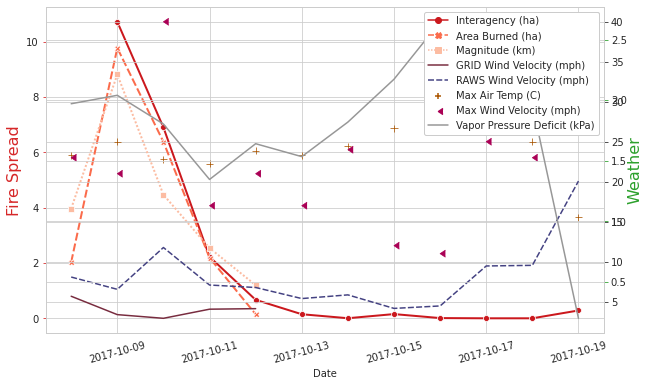

In [637]:
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True, 'framealpha':1})
sns.despine(offset=10, trim=True);

plot_options = {'labelrotation':15}

r_color = 'tab:red' # Area, Magnitude
g_color = 'tab:green' # Wind 
o_color = 'tab:orange' # Weather 

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_ylabel('Fire Spread', fontsize=16, color=r_color)
ax1 = sns.lineplot(data = area_df_plot, markers=True, palette='Reds_r', linewidth = 2)
ax1.tick_params(axis='y', color=r_color)
ax1.tick_params(axis='x', **plot_options)

ax2 = ax1.twinx()
ax2.set_ylabel('Weather', fontsize=16, color=g_color)
ax2 = sns.lineplot(data = wind_df_plot, palette='icefire_r')
ax2 = sns.scatterplot(data = maxWeather_df_plot, 
                      palette='brg_r', 
                      markers=['+', 4],
                      s=50)

ax3 = ax1.twinx()
ax3 = sns.lineplot(data = weather_df_plot, palette='Greys_r')
ax3.tick_params(axis='y', color=g_color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right', framealpha=1)


fig.savefig(f'Figures/{fire_nm}_{fire_yr}_Wind_RAWSPlot.tif', dpi=400)
fig.savefig(f'Figures/{fire_nm}_{fire_yr}_Wind_RAWSPlot.png', dpi=400)

### Daily Fuel

In [669]:
fire_nm = 'Rim'
fire_yr = '2013'
derived_df = getDerivedDF(fl_path)
derived_df_fr = derived_df[derived_df['FireName'] == fire_nm]

fuel_df_plot = derived_df_fr[[
 'Date',
 'CONIFER', 'CONIFER_HA', 'EXOTIC_HER', 'GRASSLAND', 'HARDWOOD',
 'RIPARIAN', 'SHRUBLAND', 'SPARSELY_V', 'URBAN', 'BARREN', 'DEVELOPED',
 'AGRICULTURE']]

fuel_df_plot = fuel_df_plot.set_index('Date').fillna(0)
fuel_df_plot = fuel_df_plot.sort_index()


area_df_plot = derived_df_fr[[
 'Date',
 'Area (ha)',
 'Magnitude (upperQ)', 
 'Magnitude (median)'
 ]]

area_df_plot = area_df_plot.set_index('Date')
area_df_plot = area_df_plot.sort_index()

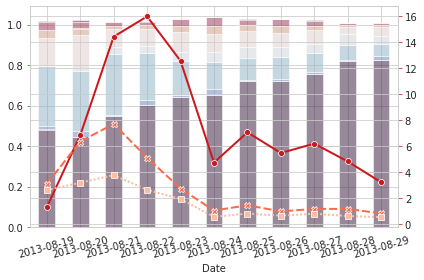

In [670]:
#fig, ax1 = plt.subplots(figsize=(10,6))
plot_options = {'labelrotation':15}
sns.set_style('whitegrid')


color = 'tab:green'
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Fuel (%) ', fontsize=16, color=color)
ax1 = fuel_df_plot.plot(kind='bar',stacked=True,legend=False, cmap='twilight_shifted', alpha=0.5)
ax1.tick_params(axis='y', color=color)
ax1.tick_params(axis='x', **plot_options)


ax2 = ax1.twinx()
color = 'tab:red'
#ax2.set_ylabel('Fire Spread', fontsize=16, color=color)
ax2 = sns.lineplot(data = area_df_plot, markers=True, legend=False, palette='Reds_r', linewidth = 2)
ax2.tick_params(axis='y', color=color)

# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2 , labels + labels2 , bbox_to_anchor=(1.20, 1.05), framealpha=1)

plt.tight_layout()
plt.savefig(f'Figures/{fire_nm}_{fire_yr}_Fuelplot.png', dpi=400)

## Largest 25 Percentile Fires

In [671]:
outPath = '/content/drive/My Drive/FireDrivers_Paper/FinalCSV_Info'
derived_df = pd.read_csv(os.path.join(outPath, 'FireInfoVar_Final.csv'), index_col=None)

In [672]:
derived_df['YearJD'] = derived_df['Year'].astype('str').str.cat(derived_df['JulianDay'].astype('str'),sep="")  
derived_df['Date'] = pd.to_datetime(derived_df['YearJD'], format= '%Y%j')
derived_df['Date'] =  derived_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
derived_df['Datetime'] = derived_df['Date'] + ' 23:00:00'
derived_df = derived_df[derived_df['Area (ha)'] != 0]
derived_df['Area (ha)'] = np.log(derived_df['Area (ha)'])

In [584]:
raws_csv_list = lstFiles(f"data/Final_CSV", '.csv')
combined_csv = pd.concat([pd.read_csv(f) for f in raws_csv_list ])

In [585]:
filt_raws = combined_csv[(combined_csv['Fire'].isin(top25_firenm))]
filt_raws['Date'] = pd.to_datetime(filt_raws['Datetime'], format= '%Y-%m-%d %H:%M:%S')
filt_raws['Date'] =  filt_raws['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
filt_raws_daily = filt_raws.groupby(by=['Date', 'Fire']).mean().reset_index()

NameError: ignored

In [ ]:
# response var: 0
# topo: 1 
# weather : 2 
# fuel : 3 
# wind : 4

var_list = {  
 'Aspect_x': 1,
 'CBD': 3,
 'CONIFER': 3,
 'CONIFER_HA': 3,
 'DEM': 1,
 'EVI': 3,
 'EXOTIC_HER': 3,
 'FBFM1': 3,
 'FBFM10': 3,
 'FBFM11': 3,
 'FBFM12': 3,
 'FBFM2': 3,
 'FBFM3': 3,
 'FBFM4': 3,
 'FBFM5': 3,
 'FBFM6': 3,
 'FBFM7': 3,
 'FBFM8': 3,
 'FBFM9': 3,
 'FFWI': 2,
 'GRASSLAND': 3,
 'HARDWOOD': 3,
 'MaxNDVI': 3,
 'NDMI': 3,
 'NDMIDelta': 3,
 'NDVI': 3,
 'RIPARIAN': 3,
 'SHRUBLAND': 3,
 'SPARSELY_V': 3,
 'Slope': 1,
 'URBAN': 3,
 'VALUE_108': 3,
 'VALUE_109': 3,
 'VALUE_110': 3,
 'VALUE_111': 3,
 'VALUE_112': 3,
 'VALUE_1': 1,
 'VALUE_2': 1,
 'VALUE_3': 1,
 'VALUE_4': 1,
 'VALUE_5': 1,
 'burningindexg': 2,
 'deadfuelmoisture1000hr': 2,
 'deadfuelmoisture100hr': 2,
 'energyreleasecomponent': 2,
 'maximumairtemperature': 2,
 'maximumrelativehumidity': 2,
 'meanvaporpressuredeficit': 2,
 'minimumairtemperature': 2,
 'minimumrelativehumidity': 2,
 #'precipitationamount': 2,
 'referenceevapotranspirationalfalfa': 2,
 'referenceevapotranspirationgrass': 2,
 'specifichumidity': 2,
 'srad': 2,
 'surfacedownwellingshortwavefluxinair': 2,
 'tmax': 2,
 'tmin': 2,
 #'windfromdirection': 2,
 'windspeed': 4,
 'BARREN': 3,
 'shortHeight': 3,
 'medShortHeight': 3,
 'medHeight': 3,
 'Total_Solar_Rad': 2,
 'Wind_Avg_mph': 4,
 #'Wind_Dir_Deg': 2,
 'Wind_Max_mph': 2,
 'Air_Temp_Avg': 2,
 'Fuel_Temp_Avg': 2,
 'Fuel_Moist_Per': 2,
 'Rel_Hum_Per': 2,
 #'Dew_Point_Deg': 2,
 #'Wet_Bulb': 2
 }

In [ ]:
def updateEcoNames(merged_rim_df):
  merged_rim_df.loc[merged_rim_df.ecoID == 5, 'NA_L3NAME'] = "Northern Coastal Sage"
  merged_rim_df.loc[merged_rim_df.ecoID == 11, 'NA_L3NAME'] = "Southern Coastal Sage"
  merged_rim_df.loc[merged_rim_df.ecoID == 8, 'NA_L3NAME'] = "Southern/Baja"
  merged_rim_df.loc[merged_rim_df.ecoID == 2, 'NA_L3NAME'] = "Southern/Baja"
  merged_rim_df.loc[merged_rim_df.ecoID == 2, 'ecoID'] = 8
  merged_rim_df.loc[merged_rim_df.ecoID == 1, 'NA_L3NAME'] = "Northern Coastal Sage"
  merged_rim_df.loc[merged_rim_df.ecoID == 1, 'ecoID'] = 5
  merged_rim_df.loc[merged_rim_df.ecoID == 0, 'NA_L3NAME'] = "Klamath Mountains"
  merged_rim_df.loc[merged_rim_df.ecoID == 0, 'ecoID'] = 7
  merged_rim_df.loc[merged_rim_df.ecoID == 12, 'NA_L3NAME'] = "Cascades"
  merged_rim_df.loc[merged_rim_df.ecoID == 12, 'ecoID'] = 3
  return merged_rim_df

In [ ]:
def get_correlation(filt_df, x, var_list):
  for key in var_list: 
    df = filt_df[filt_df[x] == key]
    corr_val = df['Area (ha)'].corr(df['value'])
    eco_region.append(ecoID)
    ind.append(ecounique)
    var_nm.append(key)
    p_cor.append(abs(corr_val))
    class_val.append(var_list[key])
    hue_val.append(q)

In [ ]:
eco_region = []
p_cor = []
var_nm = [] 
class_val = []
hue_val = []
ind = []

for i in range(0, 100 + 1, 15) :
  q = i/100
  Top25_area_val = derived_df['Area (ha)'].quantile(q)
  top25_area = derived_df[derived_df['Area (ha)'] >= Top25_area_val].reset_index()
  merged_rim_df = pd.merge(top25_area, filt_raws_daily, how='left', left_on=['Date', 'FireName'], right_on=['Date', 'Fire'])
  merged_rim_df = updateEcoNames(merged_rim_df)
  ecoID_List = merged_rim_df['NA_L3NAME'].unique().tolist()
  ecoID_name = [s + f'_{str(i)}' for s in ecoID_List]
  for ecoID, ecounique in list(zip(ecoID_List, ecoID_name)): 
    df  = merged_rim_df[(merged_rim_df['NA_L3NAME'] == ecoID)]
    filt_df = pd.melt(df, id_vars=['FireName', 'JulianDay', 'Area (ha)', 'Magnitude (upperQ)'], value_vars=list(var_list.keys())).dropna()
    get_correlation(filt_df, 'variable', var_list)

In [ ]:
for i in range(0, 100 + 1, 15) :
  print(i)

0
15
30
45
60
75
90


## Correlate by Fire

In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
corr_df = pd.DataFrame({'ind' : ind, 'eco_region': eco_region, 'hue_val': hue_val, 'var_nm': var_nm, 'p_cor': p_cor, 'class_val': class_val})
corr_df = corr_df.dropna()

In [ ]:
corr_df = corr_df[['ind', 'eco_region','hue_val', 'var_nm', 'p_cor','class_val']]
corr_df = corr_df.loc[corr_df.groupby(['ind', 'eco_region', 'class_val', 'hue_val'])['p_cor'].idxmax()].set_index(['ind']).reset_index()

In [ ]:
corr_df

In [ ]:
x_y_z = corr_df.pivot(index='ind', columns='class_val', values=['p_cor', 'var_nm']).reset_index()
x_y_z.columns = ['ind', 'Topography', 'Weather', 'Fuel', 'Wind', 'Topo_Var', 'Weather_Var', 'Fuel_Var', 'Wind_Var']
x_y_z[['eco_region','hue_val']] = x_y_z.ind.str.split("_",expand=True) 


In [ ]:
import plotly.express as px
df = px.data.election()
x_y_z['hue_val'] = x_y_z.hue_val.astype('int64')
fig = px.scatter_3d(x_y_z, x="Topography", y="Wind", z="Fuel", hover_name="eco_region", color="hue_val",
                  symbol="eco_region", color_continuous_scale='Sunset', 
                  symbol_map={'Cascades':'square', 'Klamath Mountains': 'circle-open', 'Northern Coastal Sage': 'diamond',
                                 'Sierra Nevada':'circle', 'Southern/Baja': 'diamond-open', 'Southern Coastal Sage': 'cross'})
fig.update_layout(showlegend=False)
fig.show()

### Ternary Plot

In [ ]:
!  pip install python-ternary

In [ ]:
import ternary

import plotly.express as px
df = px.data.election()
fig = px.scatter_ternary(x_y_z, a='Topo_p', b='Wind_p', c='Fuel_p',  hover_name="eco_region", color="eco_region", symbol="hue_val",
                   size_max=100, color_discrete_map = {'Topo': "blue", 'Weather': "green", 'Fuel':"red"} )
fig.show()